## Evaluate the current status of the nanocosms

all data are imported and summarized then a panel with all trajectories is created.

In [1]:
import os; os.chdir("..")  # change into root of working directory
import sys; sys.path.append("src")  # add src to system path and allow packages to be found
import pandas as pd
import itertools as it
import numpy as np
from matplotlib import pyplot as plt
import evaluation.calc as calc
from image.analysis import Data

In [14]:
data = Data.combine_data_classic(
    datapath="data/",
    interpolation_cfg={"method":"pad", "limit":1, "limit_direction":"forward"})
data.fillna(0, inplace=True)

In [15]:
data

picture_number  value  species analysis  \
time                id picture                                            
2021-04-02 08:23:20 1  0                     0   37.0    Culex     edge   
                       0                     0   33.0    Culex     edge   
                       0                     0   17.0    Culex     edge   
2021-04-02 08:29:19 2  0                     3   22.0    Culex     edge   
                       0                     3   35.0    Culex     edge   
...                                        ...    ...      ...      ...   
2021-05-07 16:35:28 77 0                   228    0.0  Daphnia   motion   
                       1                   229    0.0  Daphnia   motion   
                       1                   229    0.0  Daphnia   motion   
2021-05-07 16:35:29 77 2                   230    0.0  Daphnia   motion   
                       2                   230    0.0  Daphnia   motion   

                                        hash atnight    iso focal_length  \
time                id picture                                             
2021-04-02 08:23:20 1  0        2.487136e+09   False  400.0     3653/100   
                       0        2.487136e+09   False  400.0     3653/100   
                       0        2.487136e+09   False  400.0     3653/100   
2021-04-02 08:29:19 2  0        2.449715e+09   False  400.0       719/20   
                       0        2.449715e+09   False  400.0       719/20   
...                                      ...     ...    ...          ...   
2021-05-07 16:35:28 77 0        1.256933e+09   False  400.0       719/20   
                       1        1.256801e+09   False  400.0       719/20   
                       1        1.256801e+09   False  400.0       719/20   
2021-05-07 16:35:29 77 2        1.256502e+09   False  400.0       719/20   
                       2        1.256502e+09   False  400.0       719/20   

                               exposure_time  f_value  ... turbidity     pH  \
time                id picture                         ...                    
2021-04-02 08:23:20 1  0                1/30      5.0  ...       0.0  0.000   
                       0                1/30      5.0  ...       0.0  0.000   
                       0                1/30      5.0  ...       0.0  0.000   
2021-04-02 08:29:19 2  0                1/30      5.0  ...       0.0  0.000   
                       0                1/30      5.0  ...       0.0  0.000   
...                                      ...      ...  ...       ...    ...   
2021-05-07 16:35:28 77 0                1/25      5.0  ...       0.0  7.261   
                       1                1/25      5.0  ...       0.0  0.000   
                       1                1/25      5.0  ...       0.0  7.261   
2021-05-07 16:35:29 77 2                1/25      5.0  ...       0.0  0.000   
                       2                1/25      5.0  ...       0.0  7.261   

                                culex_larvae  culex_repro  sediment  \
time                id picture                                        
2021-04-02 08:23:20 1  0                 0.0          0.0       0.0   
                       0                 0.0          0.0       0.0   
                       0                 0.0          0.0       0.0   
2021-04-02 08:29:19 2  0                 0.0          0.0       0.0   
                       0                 0.0          0.0       0.0   
...                                      ...          ...       ...   
2021-05-07 16:35:28 77 0                15.0          0.0       0.0   
                       1                15.0          0.0       0.0   
                       1                15.0          0.0       0.0   
2021-05-07 16:35:29 77 2                15.0          0.0       0.0   
                       2                15.0          0.0       0.0   

                                culex_adults  culex_pupae  culex_add  \
time                id picture             

The next steps boil the data down

In [16]:
# get count of organisms for each picture and each analysis
groups = ["id","picture", "species", "analysis","culex_larvae", "culex_small",
          "culex_adults", "culex_pupae", "culex_repro", "sediment"]
d = calc.aggregate(
    data, 
    aggregations={"hash":"size", "value":"mean"}, 
    names=["count", "mean_size"],
    freq="S", groups=groups)

# get sum of analyses for each picture and species
groups = [g for g in groups if g != "analysis"] # remove picture from group list
d = calc.aggregate(
    d, {"count":"sum", "mean_size": "mean"}, names=[],
    freq="S", groups=groups )

# get sum of analyses for each picture and species
groups = [g for g in groups if g != "picture"] # remove picture from group list
d = calc.aggregate(
    d, {"count":"max", "mean_size": "mean"}, names=["count"],
    freq="D", groups=groups )

plot panels with trajectories of culex. Dates, where larvae counts of the image detection are exchanged with manual larvae counts have to be manually specified.

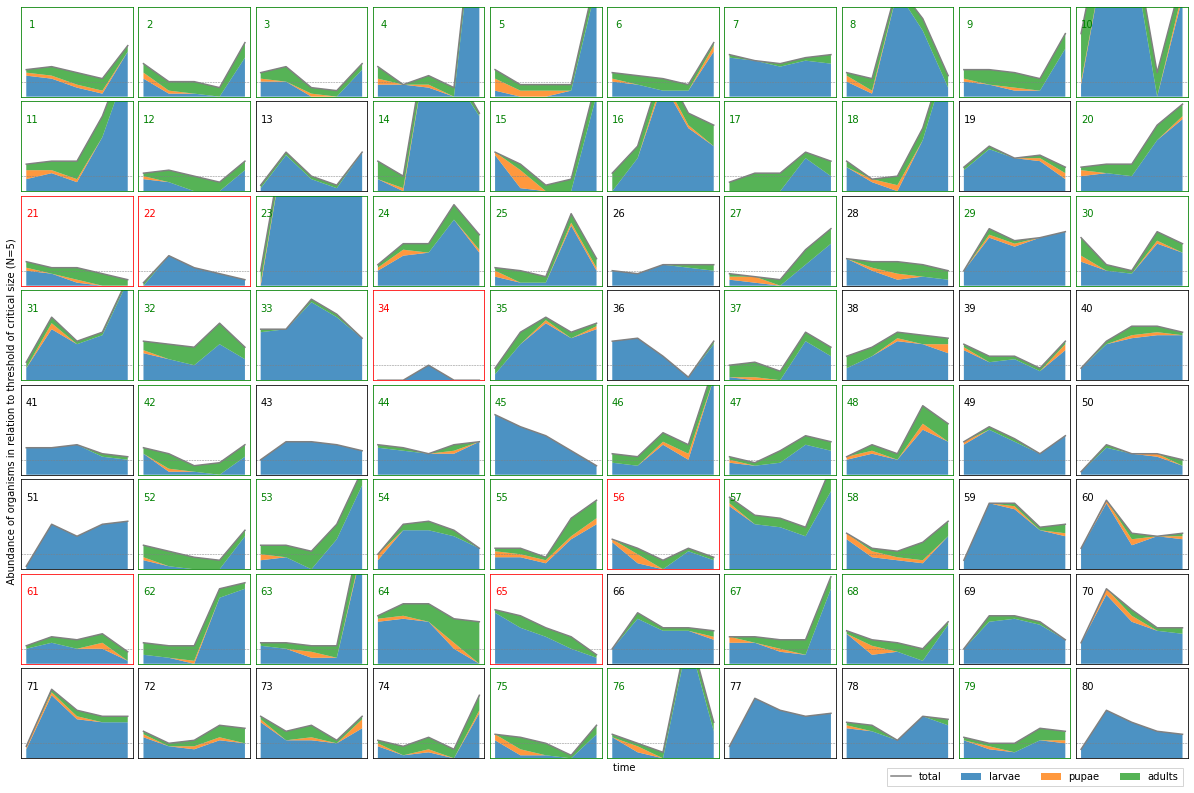

In [17]:
pdat = d.reset_index().query("species == 'Culex'").query("time == '2021-04-09' | time == '2021-04-16' | time == '2021-04-23' | time == '2021-04-30' | time == '2021-05-07'")
pdat["larvae"] = pdat["culex_larvae"] + pdat["culex_small"]
pdat["culex"] = pdat["larvae"] + pdat["culex_adults"] + pdat["culex_pupae"]
pdat.rename(columns={"culex_adults":"adults", "culex_pupae":"pupae"}, inplace=True)

fig, axes = plt.subplots(figsize=(18,12), ncols=10, nrows=8, sharex=True)
axes = axes.flatten()
for ax, i in zip(axes, np.arange(1, 81)):
    dd = pdat.query("id == @i")
    spcs = dd["species"].unique()
    for s in spcs:
        ddd = dd.query("species == @s").reset_index()
        l, = ax.plot(ddd["time"], ddd["culex"], label="total", color="gray")
        l = ax.fill_between(ddd["time"], [0], ddd["larvae"], 
                            alpha=.8, label="larvae")
        l = ax.fill_between(ddd["time"], ddd["larvae"], ddd["larvae"] + ddd["pupae"], 
                            alpha=.8, label="pupae")
        l = ax.fill_between(ddd["time"], ddd["larvae"] + ddd["pupae"], ddd["larvae"] + ddd["pupae"] + ddd["adults"],
                            alpha=.8, label="adults")
        ax.axhline(5, 0 , 100, linestyle="--", color="gray", linewidth=.5)
        ax.set_ylim(0,30)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(0.1, 0.8, str(i), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)        # ax.set_ylabel("Abundance")
        
        # color panels conditional on status
        if any(ddd.culex_repro) == True:
            plt.setp(ax.spines.values(), color="green")
            plt.setp(ax.texts, color="green")
        elif ddd.culex.to_numpy()[-1] < 5:
            plt.setp(ax.spines.values(), color="red")
            plt.setp(ax.texts, color="red")


fig.subplots_adjust(bottom=0.08, wspace=0.05, hspace=0.05, top=.95, right=0.95, left=0.05)

handles = [axes[2].lines[0]] + axes[2].collections

axes[79].legend(handles = handles, labels=["total", "larvae", "pupae", "adults"], loc='upper right', 
                bbox_to_anchor=(1, -0.05),fancybox=False, shadow=False, ncol=4)
axes[75].set_xlabel("time                         ")
axes[40].set_ylabel("            Abundance of organisms in relation to threshold of critical size (N=5)")
 
plt.savefig("plots/status_culex.jpeg")
plt.show()
